# When to go wide ?

You are close are attacking close to the line. Do you bash it up with the fowards or do you spin it wide? We will review a collection of matches from the 6-nations to answer this question. In doing so we will answer

* How many phases do you need to practise retaining the ball for ?
* What signals should your Flyhalf be looking for to know it on ?

In [2]:
# seperate out some of the details from the story
from our_code import *

# Prepare our data

In [3]:
# the path to a folder of Superscout XML files are
FOLDER = '../../datalake/Rugby/6nations/'

# Superscout defines sequence of play based on possession which is not exactly what we are after. We are 
# We have do want a sequence to start with a team ruck X meters out from the try line and ending when they 
# either score a try or lose possession. 
df = get_Sequences(FOLDER,'Ruck','Won Outright',78)

Number of Matches : 95
First game : 2014-02-21 00:00:00
Last game : 2020-09-02 00:00:00


In [4]:
df.head(10).T

,116,156,120,402,1068,117,313,157,261,403
action_id,8152427,8152428,8152429,8152430,8152431,8152432,8152433,8152434,8152435,8152436
additional,NaN,NaN,NaN,NaN,Ineffective Contact,NaN,NaN,NaN,NaN,NaN
advantage,0,0,0,0,0,0,0,0,0,0
description,NaN,NaN,NaN,NaN,Failed Gainline,NaN,Tackle Assist,NaN,NaN,NaN
event,Ruck,Pass,Pass,Tackle,Carry,Ruck,Tackle,Pass,Tackle,Tackle
event_type,NaN,Complete Pass,Complete Pass,Line Tackle,Other Carry,NaN,Line Tackle,Complete Pass,Line Tackle,Line Tackle
fixture_code,915011,915011,915011,915011,915011,915011,915011,915011,915011,915011
home_team_advantage,10,10,10,10,10,10,10,10,10,10
match_time,1026,1026,1026,1035,1035,1036,1038,1038,1042,1042
metres,0,0,0,0,0,0,0,0,0,0


We will copy the data into database as working with SQL will be easier

In [5]:
df.to_sql('tmp_attack',engine,if_exists='replace',index=False)

Lets get the regualar timelines into a SQL too incase we need it for later

In [6]:
get_Timelines(FOLDER).to_sql('tmp_timeline',engine,if_exists='replace',index=False)

Number of Matches : 95
First game : 2014-02-21 00:00:00
Last game : 2020-09-02 00:00:00


# Data Check

Before we jump in and analyse anything lets do some quick exploration of the data first. We will start with checking the volume of data. How many observations do we have as the number of rucks in a play increases. 

In [7]:
sql = """

select
fixture_code::varchar || '-' || period::varchar ||'-'|| set_num::varchar as id,
-- target
max(case when event = 'Try' then 1 else 0 end) as try,
sum(case when event = 'Ruck' then 1 else 0 end) as rucks
from
tmp_attack
where
fixture_code::varchar || period::varchar ||set_num::varchar is not null
group by
1
having 
sum(case when event = 'Carry' then 1 else 0 end) > 0 

"""
mdl_df = pd.io.sql.read_sql(sql,connection_local)

The number of observations of with greater than 18 rucks is low enough we should prob. cut the data there. We could also cut at 8 or 12. We will have to see how things look further along. 

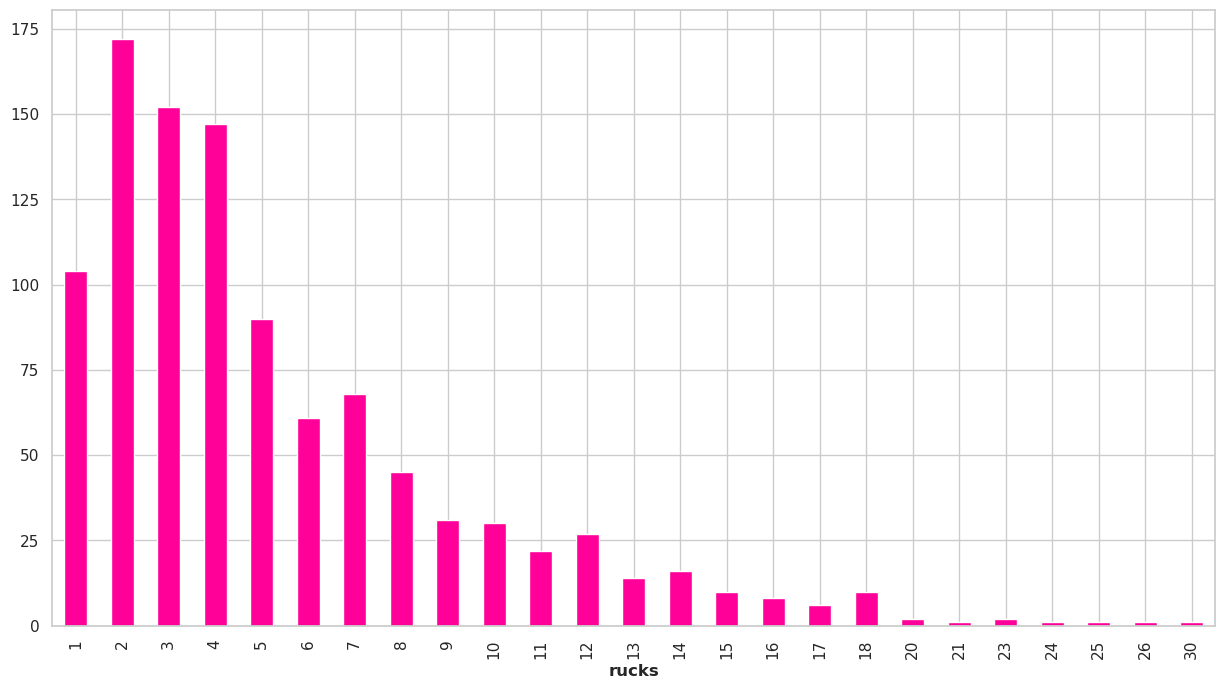

In [8]:
mdl_df.groupby('rucks')['try'].count().plot.bar()

# Simplist Solution

We will count the number of phases before the fly half calls for the ball assume that is the signal of when the ball is going to go wide.

In [84]:
sql = """

select
fixture_code::varchar || '-' || period::varchar ||'-'|| set_num::varchar as id,
-- target
max(case when event = 'Try' then 1 else 0 end) as try,
-- number of ...
max(phases) - max(case when event in ('Pass') and position = '10' then phases else 0.0 end) as phases_post_flyhalf,
max(case when event in ('Pass') and position = '10' then phases else 0.0 end) as flyhalf_calls
from
tmp_attack
where
fixture_code::varchar || period::varchar ||set_num::varchar is not null
group by
1
having 
sum(case when event = 'Carry' then 1 else 0 end) > 0 and
max(case when event in ('Pass','Carry') and position = '10' then phases else 0.0 end) < 20 and
-- cutting at 17 is prob best (trial and error)
max(phases) < 17

"""
mdl_df = pd.io.sql.read_sql(sql,connection_local,index_col='id')

mdl_df.head(10)

,try,phases_post_flyhalf,flyhalf_calls
id,,,
918032-2-47,1,4.0,0.0
918023-1-11,1,0.0,6.0
917012-2-58,1,1.0,7.0
915052-1-5,1,1.0,12.0
916011-1-12,1,0.0,10.0
916033-1-20,0,9.0,0.0
915011-2-68,0,3.0,0.0
914053-2-41,0,4.0,0.0
919023-1-46,1,4.0,0.0


In [85]:
from scipy.optimize import curve_fit
# Function to calculate the exponential with constants a and b

df_grp = mdl_df.groupby('flyhalf_calls')['try'].mean()

y_dummy = df_grp.values
x_dummy = df_grp.index.values


def trend(x, a, b):
    return a + b*x


pars, cov = curve_fit(f=trend, xdata=x_dummy, ydata=y_dummy, p0=[0, 0], bounds=(-np.inf, np.inf))


The propablity of scoring out wide increases by 0.5% every time the fowards bash it up first. 

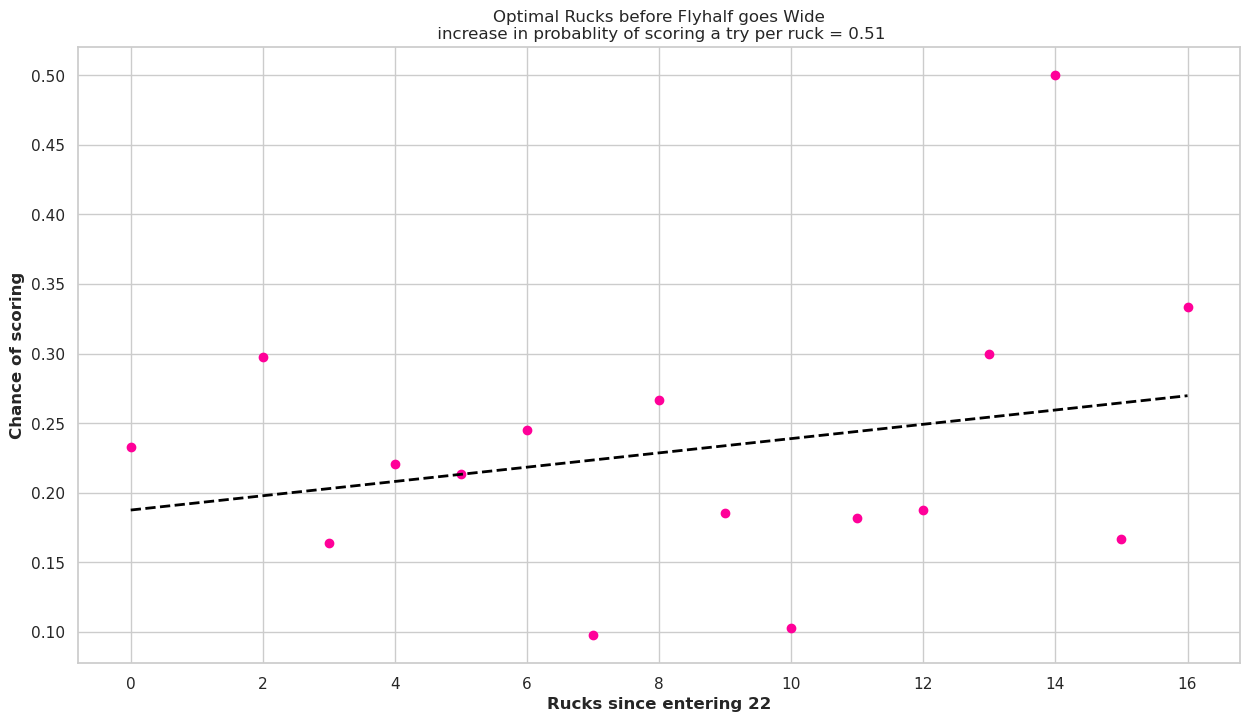

In [86]:
plt.scatter(mdl_df.groupby('flyhalf_calls')['try'].mean().index,mdl_df.groupby('flyhalf_calls')['try'].mean())
plt.plot(x_dummy, trend(x_dummy, *pars), linestyle='--', linewidth=2, color='black')
plt.title('Optimal Rucks before Flyhalf goes Wide\n increase in probablity of scoring a try per ruck = %2.2f' % (100*pars[1]))
plt.ylabel('Chance of scoring')
plt.xlabel('Rucks since entering 22')
plt.show()

So what happens after the flyhalf has asked for the ball and passed it? Turns out you need to score as quickly as possible.

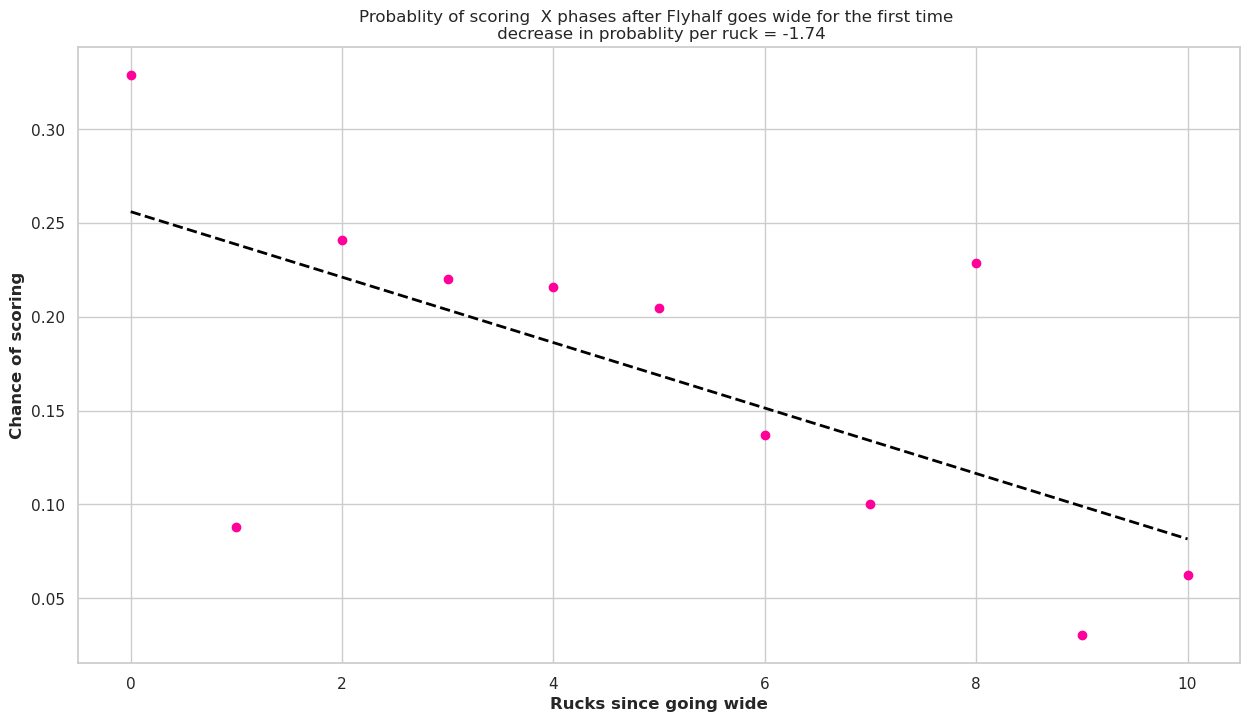

In [87]:
df2 = mdl_df.groupby('phases_post_flyhalf')['try'].mean().iloc[:11]

plt.scatter(df2.index,df2.values)

y_dummy = df2.values
x_dummy = df2.index.values


def trend(x, a, b):
    return a + b*x


pars, cov = curve_fit(f=trend, xdata=x_dummy, ydata=y_dummy, p0=[0, 0], bounds=(-np.inf, np.inf))


plt.plot(x_dummy, trend(x_dummy, *pars), linestyle='--', linewidth=2, color='black')
plt.title('Probablity of scoring  X phases after Flyhalf goes wide for the first time \n decrease in probablity per ruck = %2.2f' % (100*pars[1]))
plt.ylabel('Chance of scoring')
plt.xlabel('Rucks since going wide')
plt.show()

# So what else 

How does this answer change if we know how the first ruck was setup. Linebreak, Lineout, etc.... to do this you will need to look back at the timelines to get the start event   

In [13]:
sql = """

select
fixture_code::varchar || '-' || period::varchar ||'-'|| set_num::varchar as id,
start_event
from
tmp_timeline
where
fixture_code::varchar || period::varchar ||set_num::varchar is not null
and fixture_code::varchar || period::varchar ||set_num::varchar in (
select distinct fixture_code::varchar || period::varchar ||set_num::varchar from tmp_attack
)

"""
# we set an index col for merging 
df_starts = pd.io.sql.read_sql(sql,connection_local,index_col='id')
df_starts

,start_event
id,
915011-1-12,Kick Return
915011-1-14,Lineout
915011-1-34,Lineout
915011-2-52,Lineout
915011-2-54,Kick Return
...,...
920043-2-46,Lineout
920043-2-56,Kick Return
920043-2-59,Lineout


join the start event to our sequences that begin after the first ruck in the 22

In [89]:
mdl_df['start_event'] = df_starts['start_event']
mdl_df

,try,phases_post_flyhalf,flyhalf_calls,start_event
id,,,,
918032-2-47,1,4.0,0.0,Scrum
918023-1-11,1,0.0,6.0,Lineout
917012-2-58,1,1.0,7.0,Free Kick
915052-1-5,1,1.0,12.0,Scrum
916011-1-12,1,0.0,10.0,22m Restart
...,...,...,...,...
918011-2-98,0,0.0,4.0,Kick Return
918023-1-36,1,4.0,0.0,Kick Return
918013-1-37,0,14.0,0.0,Tap Pen


Do this but loop through all of the start events using for loop

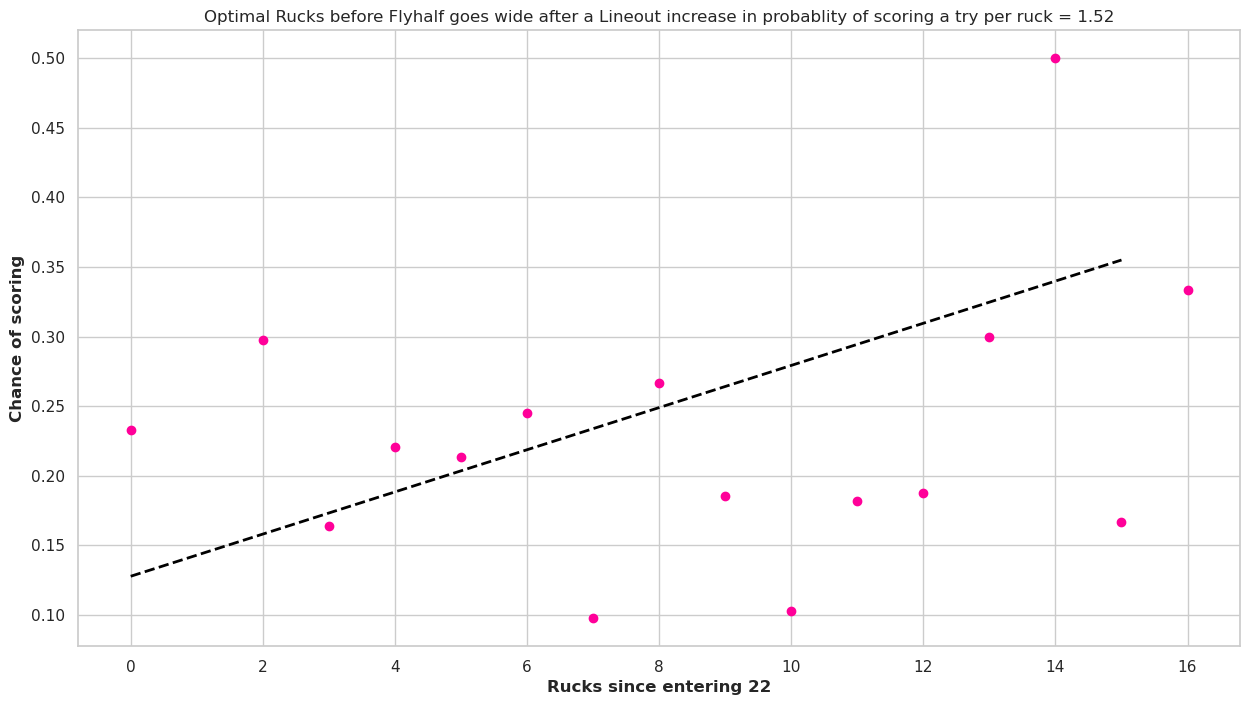

In [91]:
df_grp = mdl_df.query("start_event == 'Lineout'").groupby('flyhalf_calls')['try'].mean()

y_dummy = df_grp.values
x_dummy = df_grp.index.values


def trend(x, a, b):
    return a + b*x


pars, cov = curve_fit(f=trend, xdata=x_dummy, ydata=y_dummy, p0=[0, 0], bounds=(-np.inf, np.inf))

plt.scatter(mdl_df.groupby('flyhalf_calls')['try'].mean().index,mdl_df.groupby('flyhalf_calls')['try'].mean())
plt.plot(x_dummy, trend(x_dummy, *pars), linestyle='--', linewidth=2, color='black')
plt.title('Optimal Rucks before Flyhalf goes wide after a Lineout increase in probablity of scoring a try per ruck = %2.2f' % (100*pars[1]))
plt.ylabel('Chance of scoring')
plt.xlabel('Rucks since entering 22')
plt.show()


bonus question should you maul or go setup a ruck mid field?

# Lets get more fancy

What is the probablity a try will be scored after player X made the last tackle 

In [78]:
# for every team except England

sql = """

select
fixture_code::varchar || '-' || period::varchar ||'-'|| set_num::varchar as id,
-- target
max(case when event = 'Try' then 1 else 0 end) as try
from
tmp_attack
where
fixture_code::varchar || period::varchar ||set_num::varchar is not null
group by
1
having 
sum(case when event = 'Carry' then 1 else 0 end) > 0 and
max(case when event in ('Pass','Carry') and position = '10' then phases else 0.0 end) < 20 and
-- cutting at 17 is prob best (trial and error)
max(phases) < 17

"""
mdl_df = pd.io.sql.read_sql(sql,connection_local,index_col='id')



sql = """

with tackles as (
select
fixture_code::varchar || '-' || period::varchar ||'-'|| set_num::varchar as id,
position,
rank() over ( PARTITION BY fixture_code::varchar || '-' || period::varchar ||'-'|| set_num::varchar ORDER BY action_id) as rnk
from
tmp_attack
where
fixture_code::varchar || period::varchar ||set_num::varchar is not null
and event = 'Tackle'
and team_name <> 'England'

)
select
distinct 
t1.id, 
position as last_tackler
from 
 tackles t1 join
 (
select
id,
max(rnk) max_rnk
from
tackles
group by 1
) t2 on (t1.rnk = t2.max_rnk)
where
position < 16


"""
mdl_df2 = pd.io.sql.read_sql(sql,connection_local,index_col='id')

mdl_df = mdl_df.join(mdl_df2)

In [79]:
mdl_df.groupby('last_tackler').mean() 

,try
last_tackler,
1.0,0.213514
2.0,0.194373
3.0,0.218837
4.0,0.234501
5.0,0.211340
6.0,0.212885
7.0,0.220159
8.0,0.228426
9.0,0.265000


Text(0.5, 1.0, 'Last Player to make tackle from attacks begining in 22m')

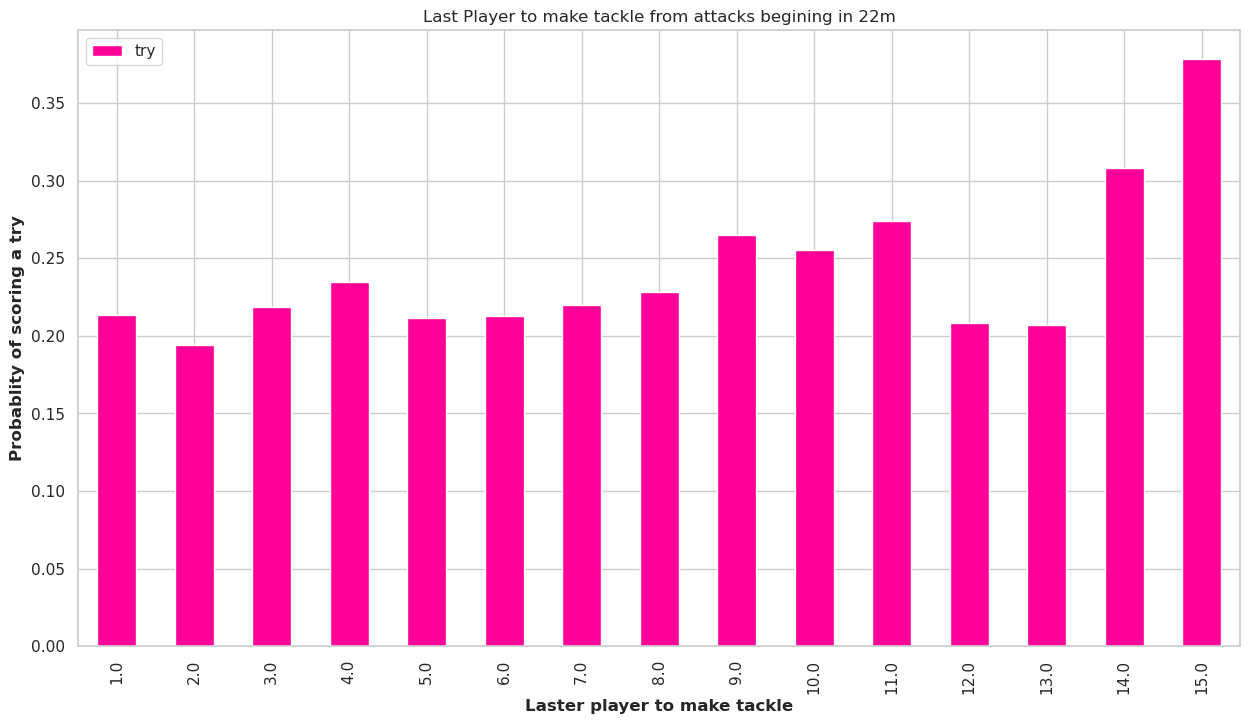

In [80]:
mdl_df.groupby('last_tackler').mean().plot.bar()
plt.xlabel('Laster player to make tackle')
plt.ylabel('Probablity of scoring a try')
plt.title('Last Player to make tackle from attacks begining in 22m')

Text(0.5, 1.0, 'Last Player to make tackle from attacks begining in 22m')

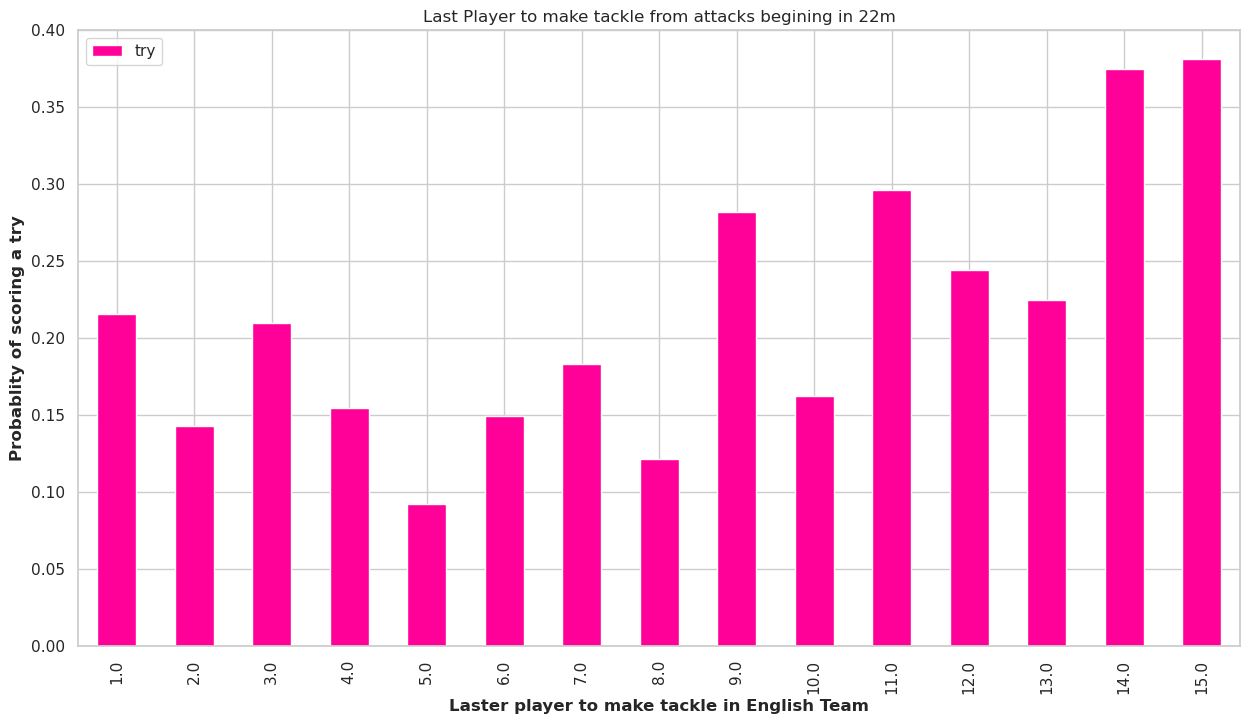

In [81]:
#just for when England was defending
TEAM = 'England'

sql = """

select
fixture_code::varchar || '-' || period::varchar ||'-'|| set_num::varchar as id,
-- target
max(case when event = 'Try' then 1 else 0 end) as try
from
tmp_attack
where
fixture_code::varchar || period::varchar ||set_num::varchar is not null
group by
1
having 
sum(case when event = 'Carry' then 1 else 0 end) > 0 and
max(case when event in ('Pass','Carry') and position = '10' then phases else 0.0 end) < 20 and
-- cutting at 17 is prob best (trial and error)
max(phases) < 17

"""
mdl_df = pd.io.sql.read_sql(sql,connection_local,index_col='id')



sql = """

with tackles as (
select
fixture_code::varchar || '-' || period::varchar ||'-'|| set_num::varchar as id,
position,
rank() over ( PARTITION BY fixture_code::varchar || '-' || period::varchar ||'-'|| set_num::varchar ORDER BY action_id) as rnk
from
tmp_attack
where
fixture_code::varchar || period::varchar ||set_num::varchar is not null
and event = 'Tackle'
and team_name = 'England'
)
select
distinct 
t1.id, 
position as last_tackler
from 
 tackles t1 join
 (
select
id,
max(rnk) max_rnk
from
tackles
group by 1
) t2 on (t1.rnk = t2.max_rnk)
where
position < 16


"""
mdl_df2 = pd.io.sql.read_sql(sql,connection_local,index_col='id')

mdl_df = mdl_df.join(mdl_df2)

mdl_df.groupby('last_tackler').mean().plot.bar()
plt.xlabel('Laster player to make tackle in English Team')
plt.ylabel('Probablity of scoring a try')
plt.title('Last Player to make tackle from attacks begining in 22m')

In [82]:
mdl_df.groupby('last_tackler').mean() 

,try
last_tackler,
1.0,0.215385
2.0,0.142857
3.0,0.209677
4.0,0.154930
5.0,0.092308
6.0,0.149254
7.0,0.183333
8.0,0.121212
9.0,0.282051
